**[SF-DST] Car Price prediction**

**Прогнозирование стоимости автомобиля по характеристикам**

Команда: 4BI

Члены команды: Икен Шынгысхан, Нурсейт Бекзат, Амангелди Ильяс

### 1. Чистка test.csv

In [580]:
import pandas as pd

In [581]:
test = pd.read_csv('test.csv')

In [582]:
import json

In [583]:
json.loads(test['super_gen'][0])

{'id': '10373605',
 'displacement': 1197,
 'engine_type': 'GASOLINE',
 'gear_type': 'FORWARD_CONTROL',
 'transmission': 'ROBOT',
 'power': 105,
 'power_kvt': 77,
 'human_name': '1.2 AMT (105 л.с.)',
 'acceleration': 10.5,
 'clearance_min': 155,
 'fuel_rate': 5}

#### Вытащим несколько переменных с super_gen

In [584]:
test['acceleration'] = [json.loads(test['super_gen'][i])['acceleration'] if ('acceleration' in test['super_gen'][i]) else 'NaN' for i in range(len(test['super_gen']))]

In [585]:
test['clearance_min'] = [json.loads(test['super_gen'][i])['clearance_min'] if ('clearance_min' in test['super_gen'][i]) else 'NaN' for i in range(len(test['super_gen']))]

In [586]:
test['power_kvt'] = [json.loads(test['super_gen'][i])['power_kvt'] if ('power_kvt' in test['super_gen'][i]) else 'NaN' for i in range(len(test['super_gen']))]

In [587]:
test['displacement'] = [json.loads(test['super_gen'][i])['displacement'] if ('displacement' in test['super_gen'][i]) else 'NaN' for i in range(len(test['super_gen']))]

In [588]:
test['fuel_rate'] = [json.loads(test['super_gen'][i])['fuel_rate'] if ('fuel_rate' in test['super_gen'][i]) else 'NaN' for i in range(len(test['super_gen']))]

In [589]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34686 entries, 0 to 34685
Data columns (total 37 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   bodyType              34686 non-null  object
 1   brand                 34686 non-null  object
 2   car_url               34686 non-null  object
 3   color                 34686 non-null  object
 4   complectation_dict    6418 non-null   object
 5   description           34686 non-null  object
 6   engineDisplacement    34686 non-null  object
 7   enginePower           34686 non-null  object
 8   equipment_dict        24690 non-null  object
 9   fuelType              34686 non-null  object
 10  image                 34686 non-null  object
 11  mileage               34686 non-null  int64 
 12  modelDate             34686 non-null  int64 
 13  model_info            34686 non-null  object
 14  model_name            34686 non-null  object
 15  name                  34686 non-null

#### Удалим оставшиеся данные с теста, так как их нет в трейне 

In [591]:
test = test.drop('car_url', axis = 1)
test = test.drop('complectation_dict', axis = 1)
test = test.drop('description', axis = 1)
test = test.drop('equipment_dict', axis = 1)
test = test.drop('vehicleConfiguration', axis = 1)
test = test.drop('image', axis = 1)
test = test.drop('model_info', axis = 1)
test = test.drop('name', axis = 1)
test = test.drop('parsing_unixtime', axis = 1)
test = test.drop('super_gen', axis = 1)
test = test.drop('priceCurrency', axis = 1)

#### Уберем LTR и N12, и сделаем из них float

In [593]:
test['engineDisplacement'] = test['engineDisplacement'].apply(lambda x: x[:-4] if 'LTR' in x else x) 

In [594]:
test['engineDisplacement'] = test['engineDisplacement'].apply(lambda x: float(x) if x != '' in x else 0) 

In [595]:
test['enginePower'] = test['enginePower'].apply(lambda x: float(x[:-4]) if 'N12' in x else (x)) 

In [596]:
test[test['fuelType'] == 'электро']['fuel_rate'].replace('NaN', 0).index

Int64Index([ 5241,  7992,  8252,  8350,  8684,  8722,  8917, 10817, 10936,
            11043, 11302, 11682, 11714, 11719, 11754, 11878, 11974, 12072,
            12085, 12100, 12250, 12287, 12334, 12466, 12481, 12558, 12582,
            12678, 12749, 12854, 12916, 12948, 12950, 13052, 13104, 13105,
            13478, 13633, 13660, 13720, 13812, 13915, 13952, 13989, 14147,
            14419, 23869, 23948, 27064, 28241, 32668, 32700, 32798, 34159,
            34504],
           dtype='int64')

#### У электро-каро нет топлива, поэтому значение 'NaN' поменяли на 0

In [597]:
test.loc[test[test['fuelType'] == 'электро']['fuel_rate'].replace('NaN', 0).index,'fuel_rate'] = 0

In [598]:
test = test.drop('sell_id', axis = 1)

In [599]:
test.to_csv('clean_test.csv', index=False) # Checkpoint

### 2. Очередь почистить запарсенные данные

In [600]:
df = pd.read_csv('all_cars.csv', low_memory=False)

In [601]:
df = df.drop_duplicates()

In [602]:
df.head()

,Название,Цена,год выпуска,Пробег,Кузов,Цвет,Двигатель,Налог,Коробка,Привод,...,fuel_rate,modelDate,model_name,url,brand,Обмен,Гарантия,Кузов №,Запас хода,Статус
0,Audi A2 2000-2007,265000₽,2001,240 000 км,хэтчбек 5 дв.,чёрный,1.4 л / 75 л.с. / Бензин,450 ₽ / год,механическая,передний,...,6 л,2000,A2,https://auto.ru/cars/used/sale/audi/a2/1089736...,AUDI,NaN,NaN,NaN,NaN,NaN
1,Audi A2 2000-2007,390000₽,2001,118 000 км,хэтчбек 5 дв.,серебристый,1.2 л / 61 л.с. / Дизель,1 464 ₽ / год,роботизированная,передний,...,2.99 л,2000,A2,https://auto.ru/cars/used/sale/audi/a2/1102039...,AUDI,Рассмотрю варианты,NaN,NaN,NaN,NaN
2,Audi A2 2000-2007,210000₽,2001,159 000 км,хэтчбек 5 дв.,серебристый,1.4 л / 75 л.с. / Бензин,387 ₽ / год,механическая,передний,...,6 л,2000,A2,https://auto.ru/cars/used/sale/audi/a2/1087512...,AUDI,NaN,NaN,NaN,NaN,NaN
3,Audi A2 2000-2007,325000₽,2001,120 000 км,хэтчбек 5 дв.,чёрный,1.4 л / 75 л.с. / Бензин,375 ₽ / год,механическая,передний,...,6 л,2000,A2,https://auto.ru/cars/used/sale/audi/a2/1098976...,AUDI,Рассмотрю варианты,NaN,NaN,NaN,NaN
4,Audi A2 2000-2007,390000₽,2000,195 857 км,хэтчбек 5 дв.,синий,1.4 л / 75 л.с. / Бензин,188 ₽ / год,механическая,передний,...,6 л,2000,A2,https://auto.ru/cars/used/sale/audi/a2/1102194...,AUDI,NaN,NaN,NaN,NaN,NaN


In [604]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 104254 entries, 0 to 104253
Data columns (total 34 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Название       104254 non-null  object 
 1   Цена           104254 non-null  object 
 2   год выпуска    104254 non-null  int64  
 3   Пробег         104254 non-null  object 
 4   Кузов          104254 non-null  object 
 5   Цвет           104254 non-null  object 
 6   Двигатель      104254 non-null  object 
 7   Налог          101636 non-null  object 
 8   Коробка        104254 non-null  object 
 9   Привод         104254 non-null  object 
 10  Руль           104254 non-null  object 
 11  Состояние      104254 non-null  object 
 12  Владельцы      104239 non-null  object 
 13  ПТС            104249 non-null  object 
 14  Владение       30017 non-null   object 
 15  Таможня        104254 non-null  object 
 16  VIN            90827 non-null   object 
 17  Госномер       79410 non-null

In [605]:
for i in df['Двигатель'].apply(lambda x: x.split(' / ', 2)): 
    if len(i) < 3:
        print(i)

#### С электрокарами была своя проблема. Решили отделить, почистить и потом опять объеденить.

In [606]:
electro = df[df['Двигатель'].apply(lambda x: x.split(' / ', 3)[2]) == 'Электро']

In [607]:
df = df.drop(index=electro.index)

In [608]:
df.insert(loc = 7, 
          column = 'engineDisplacement', 
          value = df['Двигатель'].apply(lambda x: x.split(' / ', 1)[0]))

In [609]:
df.insert(loc = 8, 
          column = 'enginePower', 
          value = df['Двигатель'].apply(lambda x: x.split(' / ', 2)[1]))

In [610]:
df.insert(loc = 9, 
          column = 'fuelType', 
          value = df['Двигатель'].apply(lambda x: x.split(' / ', 3)[2]))

In [611]:
df.head(2)

,Название,Цена,год выпуска,Пробег,Кузов,Цвет,Двигатель,engineDisplacement,enginePower,fuelType,...,fuel_rate,modelDate,model_name,url,brand,Обмен,Гарантия,Кузов №,Запас хода,Статус
0,Audi A2 2000-2007,265000₽,2001,240 000 км,хэтчбек 5 дв.,чёрный,1.4 л / 75 л.с. / Бензин,1.4 л,75 л.с.,Бензин,...,6 л,2000,A2,https://auto.ru/cars/used/sale/audi/a2/1089736...,AUDI,NaN,NaN,NaN,NaN,NaN
1,Audi A2 2000-2007,390000₽,2001,118 000 км,хэтчбек 5 дв.,серебристый,1.2 л / 61 л.с. / Дизель,1.2 л,61 л.с.,Дизель,...,2.99 л,2000,A2,https://auto.ru/cars/used/sale/audi/a2/1102039...,AUDI,Рассмотрю варианты,NaN,NaN,NaN,NaN


In [612]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 103890 entries, 0 to 104253
Data columns (total 37 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Название            103890 non-null  object 
 1   Цена                103890 non-null  object 
 2   год выпуска         103890 non-null  int64  
 3   Пробег              103890 non-null  object 
 4   Кузов               103890 non-null  object 
 5   Цвет                103890 non-null  object 
 6   Двигатель           103890 non-null  object 
 7   engineDisplacement  103890 non-null  object 
 8   enginePower         103890 non-null  object 
 9   fuelType            103890 non-null  object 
 10  Налог               101300 non-null  object 
 11  Коробка             103890 non-null  object 
 12  Привод              103890 non-null  object 
 13  Руль                103890 non-null  object 
 14  Состояние           103890 non-null  object 
 15  Владельцы           103875 non-nul

In [613]:
df['engineDisplacement'] = df['engineDisplacement'].apply(lambda x: float(x[:-5]) if 'л.с.' in x else float(x[:-2])) 

In [614]:
df['acceleration'] = df['acceleration'].fillna(df[df['acceleration'].isnull() == False]['acceleration'].median())

In [615]:
df['fuel_rate'] = df[df['fuel_rate'].isnull() == False]['fuel_rate'].apply(lambda x: float(x[:-2]))

In [616]:
df['fuel_rate'] = df['fuel_rate'].fillna(df[df['fuel_rate'].isnull() == False]['fuel_rate'].median())

In [617]:
df['clearance_min'] = df['clearance_min'].fillna('NaN')

In [618]:
df['clearance_min'] = df['clearance_min'].apply(lambda x: x.split(', ')[0] if ', ' in x else x)

In [619]:
electro['clearance_min'][7157]

'175'

In [620]:
electro.insert(loc = 7, 
          column = 'engineDisplacement', 
          value = 0)

In [621]:
electro.insert(loc = 8, 
          column = 'enginePower', 
          value = electro['Двигатель'].apply(lambda x: x.split(' / ', 2)[0]))

In [622]:
electro.insert(loc = 9, 
          column = 'fuelType', 
          value = electro['Двигатель'].apply(lambda x: x.split(' / ', 3)[2]))

In [623]:
electro.head(2)

,Название,Цена,год выпуска,Пробег,Кузов,Цвет,Двигатель,engineDisplacement,enginePower,fuelType,...,fuel_rate,modelDate,model_name,url,brand,Обмен,Гарантия,Кузов №,Запас хода,Статус
7157,Audi e-tron I,6482187₽,2019,18 500 км,внедорожник 5 дв.,серый,408 л.с. / 300 кВт / Электро,0,408 л.с.,Электро,...,NaN,2018,E_TRON,https://auto.ru/cars/used/sale/audi/e_tron/110...,AUDI,NaN,NaN,NaN,436 км,NaN
7158,Audi e-tron I,6504198₽,2019,11 650 км,внедорожник 5 дв.,голубой,408 л.с. / 300 кВт / Электро,0,408 л.с.,Электро,...,NaN,2018,E_TRON,https://auto.ru/cars/used/sale/audi/e_tron/110...,AUDI,NaN,До марта 2025,NaN,436 км,NaN


In [624]:
electro.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 364 entries, 7157 to 93686
Data columns (total 37 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Название            364 non-null    object 
 1   Цена                364 non-null    object 
 2   год выпуска         364 non-null    int64  
 3   Пробег              364 non-null    object 
 4   Кузов               364 non-null    object 
 5   Цвет                364 non-null    object 
 6   Двигатель           364 non-null    object 
 7   engineDisplacement  364 non-null    int64  
 8   enginePower         364 non-null    object 
 9   fuelType            364 non-null    object 
 10  Налог               336 non-null    object 
 11  Коробка             364 non-null    object 
 12  Привод              364 non-null    object 
 13  Руль                364 non-null    object 
 14  Состояние           364 non-null    object 
 15  Владельцы           364 non-null    object 
 16  ПТС

#### Значение поставили на ноль, так как топлива в электрокаров нет 

In [625]:
electro['displacement'] = 0

In [626]:
electro['fuel_rate'] = 0

In [627]:
electro['acceleration'] = electro['acceleration'].fillna(electro[electro['acceleration'].isnull() == False]['acceleration'].median())

In [628]:
electro['acceleration']

7157      5.7
7158      5.7
15831     7.3
15833     7.2
15835     6.9
         ... 
93675    11.5
93676    11.5
93677    11.5
93680    11.5
93686    11.5
Name: acceleration, Length: 364, dtype: float64

In [629]:
electro.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 364 entries, 7157 to 93686
Data columns (total 37 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Название            364 non-null    object 
 1   Цена                364 non-null    object 
 2   год выпуска         364 non-null    int64  
 3   Пробег              364 non-null    object 
 4   Кузов               364 non-null    object 
 5   Цвет                364 non-null    object 
 6   Двигатель           364 non-null    object 
 7   engineDisplacement  364 non-null    int64  
 8   enginePower         364 non-null    object 
 9   fuelType            364 non-null    object 
 10  Налог               336 non-null    object 
 11  Коробка             364 non-null    object 
 12  Привод              364 non-null    object 
 13  Руль                364 non-null    object 
 14  Состояние           364 non-null    object 
 15  Владельцы           364 non-null    object 
 16  ПТС

#### Объеденяем с электрокарами

In [630]:
df = pd.concat([df, electro], ignore_index = True)

#### Нужно убрать валюту с цены (Рубль), чтобы сделать колонку числовым типом

In [631]:
df['Цена'].head()

0    265000₽
1    390000₽
2    210000₽
3    325000₽
4    390000₽
Name: Цена, dtype: object

In [632]:
df['Цена'] = df['Цена'].apply(lambda x: int(x[3:-1]) if ('от' in x) else int(x[:-1]))

In [633]:
import re

In [634]:
df['Пробег'] = df['Пробег'].apply(lambda x: int(re.sub(r'(\d)\s+(\d)', r'\1\2', x[:-3])))

In [635]:
df['enginePower'] = df['enginePower'].apply(lambda x: float(x[:-4]) if 'кВт' in x else float(x[:-5])) 

#### Изменили наименование колонок под тест

In [636]:
df = df.rename({"Кузов":"bodyType","Марка":"brand", "Цвет": "color", "Пробег": "mileage", "год выпуска": "productionDate", "Model": "brand", "Коробка": "vehicleTransmission"}, axis='columns')

In [637]:
test.columns

Index(['bodyType', 'brand', 'color', 'engineDisplacement', 'enginePower',
       'fuelType', 'mileage', 'modelDate', 'model_name', 'numberOfDoors',
       'productionDate', 'vehicleTransmission', 'vendor', 'Владельцы',
       'Владение', 'ПТС', 'Привод', 'Руль', 'Состояние', 'Таможня',
       'acceleration', 'clearance_min', 'power_kvt', 'displacement',
       'fuel_rate'],
      dtype='object')

#### Датафрейм у которого очередность колонок такая же как в тест 

In [638]:
data = pd.DataFrame()
for i in ['bodyType', 'brand', 'color', 'engineDisplacement', 'enginePower',
       'fuelType', 'mileage', 'modelDate', 'model_name', 'numberOfDoors',
       'productionDate', 'vehicleTransmission', 'vendor', 'Владельцы',
       'Владение', 'ПТС', 'Привод', 'Руль', 'Состояние', 'Таможня', 'Цена'
       ,'acceleration', 'clearance_min', 'power_kvt', 'displacement',
       'fuel_rate']:
    data[f'{i}'] = df[f'{i}']

In [639]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104254 entries, 0 to 104253
Data columns (total 26 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   bodyType             104254 non-null  object 
 1   brand                104254 non-null  object 
 2   color                104254 non-null  object 
 3   engineDisplacement   104254 non-null  float64
 4   enginePower          104254 non-null  float64
 5   fuelType             104254 non-null  object 
 6   mileage              104254 non-null  int64  
 7   modelDate            104254 non-null  int64  
 8   model_name           104254 non-null  object 
 9   numberOfDoors        104254 non-null  int64  
 10  productionDate       104254 non-null  int64  
 11  vehicleTransmission  104254 non-null  object 
 12  vendor               104254 non-null  object 
 13  Владельцы            104239 non-null  object 
 14  Владение             30017 non-null   object 
 15  ПТС              

In [640]:
data.to_csv('data.csv', index=False) # Cheockpoint

#### Обозначим трейн и тест перед их объеденением.

In [641]:
test['label'] = 1
data['label'] = 0

In [642]:
combined = pd.concat([data, test], ignore_index=True)

In [643]:
combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 138940 entries, 0 to 138939
Data columns (total 27 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   bodyType             138940 non-null  object 
 1   brand                138940 non-null  object 
 2   color                138940 non-null  object 
 3   engineDisplacement   138940 non-null  float64
 4   enginePower          138940 non-null  float64
 5   fuelType             138940 non-null  object 
 6   mileage              138940 non-null  int64  
 7   modelDate            138940 non-null  int64  
 8   model_name           138940 non-null  object 
 9   numberOfDoors        138940 non-null  int64  
 10  productionDate       138940 non-null  int64  
 11  vehicleTransmission  138940 non-null  object 
 12  vendor               138940 non-null  object 
 13  Владельцы            138925 non-null  object 
 14  Владение             42012 non-null   object 
 15  ПТС              

### Предобработка

In [644]:
combined.loc[combined[combined['fuelType'] == 'электро']['fuel_rate'].replace('NaN', 0).index, 'fuel_rate'] = 0

In [645]:
combined.loc[combined[combined['fuel_rate'] == 'NaN'].index, 'fuel_rate'] = combined['fuel_rate'].median()

In [646]:
combined.loc[combined[combined['fuel_rate'] == 'NaN'].index, 'fuel_rate'] = combined['fuel_rate'].median()

In [647]:
combined.loc[combined[combined['acceleration'] == 'NaN'].index, 'acceleration'] = combined['acceleration'].median()

In [648]:
combined['acceleration'] = combined['acceleration'].apply(lambda x: float(x))

In [649]:
combined.loc[combined[combined['clearance_min'] == 'NaN'].index, 'clearance_min'] = combined['clearance_min'].median()

In [650]:
combined['clearance_min'] = combined['clearance_min'].apply(lambda x: float(x))

In [651]:
combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 138940 entries, 0 to 138939
Data columns (total 27 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   bodyType             138940 non-null  object 
 1   brand                138940 non-null  object 
 2   color                138940 non-null  object 
 3   engineDisplacement   138940 non-null  float64
 4   enginePower          138940 non-null  float64
 5   fuelType             138940 non-null  object 
 6   mileage              138940 non-null  int64  
 7   modelDate            138940 non-null  int64  
 8   model_name           138940 non-null  object 
 9   numberOfDoors        138940 non-null  int64  
 10  productionDate       138940 non-null  int64  
 11  vehicleTransmission  138940 non-null  object 
 12  vendor               138940 non-null  object 
 13  Владельцы            138925 non-null  object 
 14  Владение             42012 non-null   object 
 15  ПТС              

In [652]:
combined['ПТС'] = combined['ПТС'].fillna('Оригинал') # Заполним пустые значения в ПТС самым распростронённым

In [653]:
combined['fuelType'] = combined['fuelType'].apply(lambda x: 'бензин' if x == 'Бензин' else x)
combined['fuelType'] = combined['fuelType'].apply(lambda x: 'дизель' if x == 'Дизель' else x)
combined['fuelType'] = combined['fuelType'].apply(lambda x: 'гибрид' if x == 'Гибрид' else x)

In [654]:
combined['fuelType'] = combined['fuelType'].apply(lambda x: 'газ' if x == 'Бензин, газобаллонное оборудование' else x)

In [655]:
combined['fuelType'] = combined['fuelType'].apply(lambda x: 'газ' if x == 'Газ, газобаллонное оборудование' else x)
combined['fuelType'] = combined['fuelType'].apply(lambda x: 'газ' if x == 'Гибрид, газобаллонное оборудование' else x)
combined['fuelType'] = combined['fuelType'].apply(lambda x: 'электро' if x == 'Электро' else x)
combined['fuelType'] = combined['fuelType'].apply(lambda x: 'газ' if x == 'Газ' else x)

In [656]:
combined['fuelType'] = combined['fuelType'].apply(lambda x: 'газ' if x == 'Дизель, газобаллонное оборудование' else x)

In [657]:
combined['model_name'].value_counts()

OCTAVIA    4336
5ER        4031
A6         2793
LANCER     2645
3ER        2555
           ... 
2             1
ORIGIN        1
M1            1
140           1
POPULAR       1
Name: model_name, Length: 545, dtype: int64

####  Импортируем LabelEncoder для работы с категориальными данными

In [658]:
from sklearn.preprocessing import LabelEncoder 

In [659]:
combined['Привод'] = pd.Series(LabelEncoder().fit_transform(combined['Привод']))

In [660]:
combined['ПТС'] = pd.Series(LabelEncoder().fit_transform(combined['ПТС']))

In [661]:
combined['vendor'].value_counts()

Япония      53016
Германия    42966
EUROPEAN    20682
JAPANESE    14004
Чехия        6778
Швеция       1494
Name: vendor, dtype: int64

In [662]:
combined['vendor'] = combined['vendor'].apply(lambda x: 'JAPANESE' if x == 'Япония' else x)
combined['vendor'] = combined['vendor'].apply(lambda x: 'EUROPEAN' if x == 'Германия' else x)
combined['vendor'] = combined['vendor'].apply(lambda x: 'EUROPEAN' if x == 'Чехия' else x)
combined['vendor'] = combined['vendor'].apply(lambda x: 'EUROPEAN' if x == 'Швеция' else x)

In [663]:
combined['Состояние'].value_counts()

Не требует ремонта    138940
Name: Состояние, dtype: int64

#### Нет смысла в этой переменной

In [664]:
combined = combined.drop('Состояние', axis = 1)

In [665]:
# combined = combined.drop('displacement', axis = 1)
# combined = combined.drop('power_kvt', axis = 1)

In [666]:
combined['Руль'] = pd.Series(LabelEncoder().fit_transform(combined['Руль']))

In [667]:
combined['Таможня'].value_counts()

Растаможен    138940
Name: Таможня, dtype: int64

In [668]:
combined = combined.drop('Таможня', axis = 1)

In [669]:
import re

In [670]:
combined['bodyType'] = combined['bodyType'].apply(lambda x: (re.match(r'\w+', x)).group())

In [671]:
combined['bodyType'] = pd.Series(LabelEncoder().fit_transform(combined['bodyType']))

In [672]:
combined['color'] = pd.Series(LabelEncoder().fit_transform(combined['color']))

In [673]:
combined['brand'] = pd.Series(LabelEncoder().fit_transform(combined['brand']))

In [674]:
combined['fuelType'] = pd.Series(LabelEncoder().fit_transform(combined['fuelType']))

In [675]:
combined['model_name'] = pd.Series(LabelEncoder().fit_transform(combined['model_name']))

In [676]:
combined['vehicleTransmission'] = pd.Series(LabelEncoder().fit_transform(combined['vehicleTransmission']))

In [677]:
combined['vendor'] = pd.Series(LabelEncoder().fit_transform(combined['vendor']))

In [678]:
combined['mileage'].describe()

count     138940.000000
mean      172477.231172
std       106812.663321
min            1.000000
25%        96000.000000
50%       159000.000000
75%       231773.250000
max      1000000.000000
Name: mileage, dtype: float64

In [679]:
def fun(year):
    if year > 2010:
        a ='1 владелец'
        return '1\xa0владелец'     #  '1 владелец'#  1\xa0владелец
    elif year > 2000:
        return '2\xa0владельца'    #'2 владелеца' # 2\xa0владельца
    elif year <2000:
        return '3 или более'

In [680]:
combined['Владельцы'][combined['Владельцы'].isna()==True] = combined.productionDate[combined['Владельцы'].isna()==True].apply(fun)

<ipython-input-680-868564c1c71a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined['Владельцы'][combined['Владельцы'].isna()==True] = combined.productionDate[combined['Владельцы'].isna()==True].apply(fun)


In [681]:
combined['Владельцы'].value_counts()

3 или более    71773
1 владелец     33980
2 владельца    33187
Name: Владельцы, dtype: int64

In [682]:
combined['Владельцы'] = pd.Series(LabelEncoder().fit_transform(combined['Владельцы']))

In [683]:
combined = combined.drop('Владение', axis = 1)

In [684]:
# combined = combined.drop('modelDate', axis = 1)

### Новые признаки/переменные

Разница между годом выпуска и годом моделя

In [685]:
combined['diffAge'] = combined['productionDate'] - combined['modelDate']

На сколько модель старая

In [686]:
combined['oldAge'] = 2021 - combined['modelDate']

Сколько прошло лет с года выпуска

In [687]:
combined['fromProdAge'] = 2021 - combined['productionDate']

Функция для расчета налога. К сожалению она не точная. Не хватает двух переменных для точного расчета. Но на сайте https://zakon-auto.ru/info/tnalog/moscow.php написано что это стандартная формула

In [688]:
def fun_tax(power, year):
    if power <=100:
        stavka =12
    elif power <=125 and power >100 :
        stavka =25
    elif power <=150 and power >125 :
        stavka =35
    elif power <=175 and power >150 :
        stavka =45
    elif power <=200 and power >175 :
        stavka =50
    elif power <=225 and power >200 :
        stavka =65
    elif power <=250 and power >225 :
        stavka =75
    elif power >250 :
        stavka =150
    year = 2021 - year
    return stavka * power

In [689]:
combined['Tax'] = combined[['enginePower','productionDate']].apply(lambda x: fun_tax(x['enginePower'], x['productionDate']), axis=1)

In [690]:
combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 138940 entries, 0 to 138939
Data columns (total 28 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   bodyType             138940 non-null  int32  
 1   brand                138940 non-null  int32  
 2   color                138940 non-null  int32  
 3   engineDisplacement   138940 non-null  float64
 4   enginePower          138940 non-null  float64
 5   fuelType             138940 non-null  int32  
 6   mileage              138940 non-null  int64  
 7   modelDate            138940 non-null  int64  
 8   model_name           138940 non-null  int32  
 9   numberOfDoors        138940 non-null  int64  
 10  productionDate       138940 non-null  int64  
 11  vehicleTransmission  138940 non-null  int32  
 12  vendor               138940 non-null  int32  
 13  Владельцы            138940 non-null  int32  
 14  ПТС                  138940 non-null  int32  
 15  Привод           

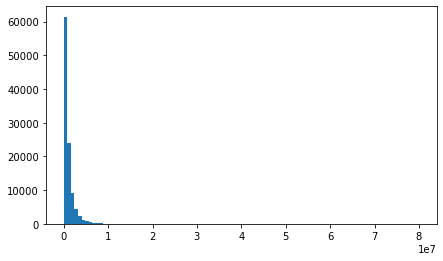

In [691]:
from matplotlib import pyplot as plt 

fig, ax = plt.subplots(figsize =(7, 4)) 
ax.hist(df['Цена'], bins = 100) 
  
# Show plot 
plt.show() 

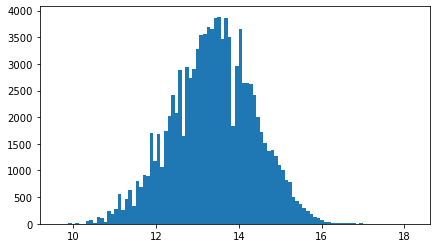

In [692]:
from matplotlib import pyplot as plt 

fig, ax = plt.subplots(figsize =(7, 4)) 
ax.hist(np.log(df['Цена']), bins = 100) 
  
# Show plot 
plt.show() 

#### Предсказание с логарифмическими ценами показали низкий МАРЕ

In [693]:
Y_train = np.log(df['Цена'])

#### Делим на train и test

In [694]:
X_test = combined[combined['label'] == 1].drop('label', axis = 1)
X_train = combined[combined['label'] == 0].drop('label', axis = 1)

In [697]:
X_train = X_train.drop('Цена', axis=1)
X_test = X_test.drop('Цена', axis=1)

###  Обучение. Модели.

In [ ]:
from sklearn.ensemble import StackingRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.linear_model import LinearRegression
import xgboost as xgb
from catboost import CatBoostRegressor

### Random Forest Reggresor

#### Часто показывал довольно хороший результат. Но уступил XGBoost

In [703]:
model = RandomForestRegressor(n_estimators=1000, max_depth=15, random_state=42)

In [704]:
model.fit(X_train, Y_train)

RandomForestRegressor(max_depth=15, n_estimators=1000, random_state=42)

In [705]:
pred = model.predict(X_test)

In [707]:
pred = np.exp(pred)

In [284]:
pred

array([ 727550.10495192, 1050006.5789351 ,  870271.47132974, ...,
        249354.7109464 , 1169557.44699161, 1157549.68209116])

In [708]:
pred

array([ 707607.73052455, 1050298.83425229,  877975.48744975, ...,
        250031.69825353, 1167976.99191724, 1144223.36843878])

In [710]:
sample_submission = pd.read_csv('sample_submission.csv')
sample_submission['price'] = pred
sample_submission.to_csv(f'submission_31.csv', index=False)

### Стакинг

#### Сколько не пытались стакинг показывал результат хуже чем отдельных алгоритов. В добавок требовало много времени обучения.

In [311]:
estimators=[('b_gbr', BaggingRegressor(GradientBoostingRegressor(random_state=42
                                                                ,n_estimators=800
                                                                ,min_samples_split=5
                                                                ,min_samples_leaf=4
                                                                ,max_features='sqrt'
                                                                ,max_depth=9)
                                                                ,n_estimators=3
                                                                ,n_jobs=1
                                                                ,random_state=42))
            ,('xgb', xgb.XGBRegressor(objective='reg:squarederror'
                                      ,colsample_bytree=0.5
                                      ,learning_rate=0.05
                                      ,max_depth=12
                                      ,alpha=1
                                      ,n_estimators=1000)),
           ('cat', CatBoostRegressor(iterations = 500
                             ,random_seed = 42
                             ,eval_metric='MAPE'
                             ,custom_metric=['R2', 'MAE']
                             ,silent=True
                             ,learning_rate=0.13
                             ,depth=12
                             ,l2_leaf_reg=8
                             ,random_strength=0.3))] 

In [313]:
st_ensemble = StackingRegressor(estimators=estimators
                                ,final_estimator = LinearRegression(n_jobs=-1))

In [314]:
st_ensemble.fit(X_train, Y_train)

StackingRegressor(estimators=[('b_gbr',
                               BaggingRegressor(base_estimator=GradientBoostingRegressor(max_depth=9,
                                                                                         max_features='sqrt',
                                                                                         min_samples_leaf=4,
                                                                                         min_samples_split=5,
                                                                                         n_estimators=800,
                                                                                         random_state=42),
                                                n_estimators=3, n_jobs=1,
                                                random_state=42)),
                              ('xgb',
                               XGBRegressor(alpha=1, base_score=None,
                                            booster=None,
        

In [315]:
pred = np.exp(st_ensemble.predict(X_test))

In [316]:
pred

array([ 668870.92220953, 1049863.86309845,  870466.63273068, ...,
        243107.32836649, 1116192.54705518, 1132846.97518519])

In [862]:
pred

array([ 628078.48670855,  989032.37491784,  862507.2541245 , ...,
        236773.38636264, 1292443.58046609, 1157041.67885418])

In [317]:
sample_submission = pd.read_csv('sample_submission.csv')
sample_submission['price'] = pred
sample_submission['price'] = sample_submission['price'].fillna(sample_submission['price'].mean())
sample_submission.to_csv(f'submission_25.csv', index=False)

### Бэггинг

#### Тоже не помогло

In [864]:
bagg_xgb = BaggingRegressor(xgb.XGBRegressor(objective='reg:squarederror', colsample_bytree=0.5,
                          learning_rate=0.05, max_depth=17, alpha=1,
                          n_estimators=1000), n_estimators=3, n_jobs=1, random_state=42)

In [865]:
bagg_xgb.fit(X_train, Y_train)

BaggingRegressor(base_estimator=XGBRegressor(alpha=1, base_score=None,
                                             booster=None,
                                             colsample_bylevel=None,
                                             colsample_bynode=None,
                                             colsample_bytree=0.5, gamma=None,
                                             gpu_id=None,
                                             importance_type='gain',
                                             interaction_constraints=None,
                                             learning_rate=0.05,
                                             max_delta_step=None, max_depth=17,
                                             min_child_weight=None, missing=nan,
                                             monotone_constraints=None,
                                             n_estimators=1000, n_jobs=None,
                                             num_parallel_tree=None,
        

In [866]:
predict_bagg_xgb = np.exp(bagg_xgb.predict(X_test))

In [867]:
predict_submission = np.round(predict_bagg_xgb ,-3)

In [868]:
predict_bagg_xgb 

array([ 692637.6 , 1054393.1 ,  889529.7 , ...,  215096.89, 1201077.6 ,
       1191785.2 ], dtype=float32)

In [869]:
predict_submission

array([ 693000., 1054000.,  890000., ...,  215000., 1201000., 1192000.],
      dtype=float32)

In [875]:
sample_submission = pd.read_csv('sample_submission.csv')
sample_submission['price'] = predict_bagg_xgb 
# sample_submission['price'] = sample_submission['price'].fillna(sample_submission['price'].mean())
sample_submission.to_csv(f'submission_21.csv', index=False)

### Градиентный бустинг

#### По результатам был на уровне Random Forest

In [296]:
gb = GradientBoostingRegressor(min_samples_split=2, learning_rate=0.03, max_depth=15, n_estimators=1000)
gb.fit(X_train, Y_train)

GradientBoostingRegressor(learning_rate=0.03, max_depth=15, n_estimators=1000)

In [297]:
pred = np.exp(gb.predict(X_test))

In [298]:
predict_submission = np.round(pred ,-3)

In [61]:
predict_submission

array([ 456000.,  863000.,  706000., ..., 1155000., 1293000., 2106000.])

In [299]:
predict_submission

array([ 762000.,  975000.,  827000., ...,  193000., 1224000., 1177000.])

In [55]:
predict_submission 

array([ 573000.,  721000.,  734000., ...,  994000., 1331000., 1376000.])

In [56]:
sample_submission = pd.read_csv('sample_submission.csv')
sample_submission['price'] = predict_submission
# sample_submission['price'] = sample_submission['price'].fillna(sample_submission['price'].mean())
sample_submission.to_csv(f'submission_23.csv', index=False)

### XGBoost

#### Наш фаворит. Показал наилучший результат в kaggle - 10.83704. К удивлению заняло не так много времени обучения.

In [243]:
xg_reg = xgb.XGBRegressor(objective='reg:squarederror', colsample_bytree=0.5,
                          learning_rate=0.005, max_depth=15, alpha=1,
                          n_estimators=1000)
xg_reg.fit(X_train, Y_train)

XGBRegressor(alpha=1, base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.5, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.005, max_delta_step=0, max_depth=15,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=1, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [244]:
xg_red_pred = xg_reg.predict(X_test)

In [245]:
np.exp(xg_red_pred)

array([ 612603.9 ,  883710.7 ,  863112.75, ...,  242010.9 , 1184876.9 ,
       1038862.3 ], dtype=float32)

In [306]:
predict_submission

array([ 762000.,  975000.,  827000., ...,  193000., 1224000., 1177000.])

In [309]:
np.exp(xg_red_pred)

array([ 693228.4, 1041141.5,  879525.3, ...,  230193.8, 1196114.4,
       1177713. ], dtype=float32)

In [246]:
sample_submission = pd.read_csv('sample_submission.csv')
sample_submission['price'] = np.exp(xg_red_pred)
# sample_submission['price'] = sample_submission['price'].fillna(sample_submission['price'].mean())
sample_submission.to_csv(f'submission_29.csv', index=False)

In [439]:
xg_reg = xgb.XGBRegressor(objective='reg:squarederror', colsample_bytree=0.5,
                          learning_rate= 0.005 ,max_depth=15, alpha=1,
                          n_estimators=5000)
xg_reg.fit(X_train, Y_train)

XGBRegressor(alpha=1, base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.5, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.005, max_delta_step=0, max_depth=15,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=5000, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=1, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [442]:
importances = list(xg_reg.feature_importances_)
feature_list = ['bodyType', 'brand', 'color', 'engineDisplacement', 'enginePower',
       'fuelType', 'mileage', 'modelDate', 'model_name', 'numberOfDoors',
       'productionDate', 'vehicleTransmission', 'vendor', 'ПТС', 'Привод',
       'Руль', 'acceleration', 'clearance_min', 'power_kvt', 'displacement',
       'fuel_rate', 'diffAge', 'oldAge', 'fromProdAge']
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
# [('Variable: {:20} Importance: {}'.format(i[0], i[1])) for i in feature_importances]
for i in feature_importances:
    print('Variable: {:20} Importance: {}'.format(i[0], i[1]))

Variable: oldAge               Importance: 0.18000000715255737
Variable: modelDate            Importance: 0.17000000178813934
Variable: productionDate       Importance: 0.14000000059604645
Variable: fromProdAge          Importance: 0.14000000059604645
Variable: power_kvt            Importance: 0.07999999821186066
Variable: Привод               Importance: 0.05999999865889549
Variable: engineDisplacement   Importance: 0.03999999910593033
Variable: enginePower          Importance: 0.03999999910593033
Variable: displacement         Importance: 0.03999999910593033
Variable: bodyType             Importance: 0.029999999329447746
Variable: brand                Importance: 0.019999999552965164
Variable: fuelType             Importance: 0.009999999776482582
Variable: mileage              Importance: 0.009999999776482582
Variable: numberOfDoors        Importance: 0.009999999776482582
Variable: vehicleTransmission  Importance: 0.009999999776482582
Variable: vendor               Importance: 0.0099

In [172]:
predict_test = np.exp(xg_reg.predict(X_test)) 

In [142]:
predict_test

array([ 695271.6 , 1021706.3 ,  884817.94, ...,  220242.08, 1189450.8 ,
       1175652.6 ], dtype=float32)

In [173]:
predict_test

array([ 638878. ,  971148.7,  940239.6, ...,  271114.6, 1123685.1,
       1082229.8], dtype=float32)

In [486]:
predict_test

array([ 639422.94,  975085.4 ,  941749.94, ...,  269290.94, 1128986.1 ,
       1087985.6 ], dtype=float32)

In [219]:
sample_submission = pd.read_csv('sample_submission.csv')
sample_submission['price'] = predict
# sample_submission['price'] = sample_submission['price'].fillna(sample_submission['price'].mean())
sample_submission.to_csv(f'submission_29.csv', index=False)

### CatBoost

#### Пробовали с транформированными и без трансформирования категориальных данных. В итоге показал результат хуже чем в Random Forest и Gradient Boosting. Также занимало долгое время.

In [214]:
model = CatBoostRegressor(iterations = 500,
                          cat_features=cat_cols,
                          random_seed = 42,
                          eval_metric='MAPE',
                          custom_metric=['R2', 'MAE'],
                          silent=True,
                          learning_rate=0.05,
                          depth=15,
                          l2_leaf_reg=8,
                          random_strength=0.3
                         )

In [215]:
model.fit(X_train, Y_train,
         use_best_model=True,
         verbose=False,
         )

You should provide test set for use best model. use_best_model parameter has been switched to false value.


In [203]:
cat_cols = ['bodyType', 'brand', 'color', 'fuelType', 'model_name', 'vehicleTransmission', 'vendor', 'ПТС', 'Привод', 'Руль']

In [216]:
predict = np.exp(model.predict(X_test))

In [218]:
predict

array([ 696252.16985087, 1005008.61481104,  949926.02300435, ...,
        250194.46001757, 1258897.52008821, 1182168.32349922])

In [713]:
predict

array([ 707607.73052455, 1050298.83425229,  877975.48744975, ...,
        250031.69825353, 1167976.99191724, 1144223.36843878])